# Read in data

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np

from process_raw_hector_output import *

In [2]:
# Emissions driven simulations

fpath = '/home/jovyan/normalizing-cdr-accounting/carbonplan_normalizing_cdr/data/hector-output/'

fname='idealized_removals_from_preindustrial/outputstream_DOR_LLremoval_10GtCO2_trackingOn.csv'
ds_fromOcn_emisDriven=process_csv_to_xarray(fpath+fname, startyear=1750, filetype='C++')

fname = 'idealized_removals_from_preindustrial/outputstream_DAC_10GtCO2_trackingOn.csv'
ds_fromAtm_emisDriven=process_csv_to_xarray(fpath+fname, startyear=1750, filetype='C++')

In [3]:
# Concentration driven simulations
fname = 'concentration_driven/outputstream_idealized_DOR_10GtCO2_removal_fixedCO2ppm.csv'
ds_fromOcn_concDriven=process_csv_to_xarray(fpath+fname, startyear=1750, filetype='C++')#, skiprows=2)

fname = 'concentration_driven/outputstream_idealized_DAC_10GtCO2_removal_fixedCO2ppm.csv'
ds_fromAtm_concDriven=process_csv_to_xarray(fpath+fname, startyear=1750, filetype='C++')#, skiprows=2)

# Process data

In [5]:
unitconv=44.01/12.011

# Make new datasets that drop spinup

# For DOR, need to start time series one year later because
# DOR is implemented at the end of the time step, while DAC is implemented at 
# the beginning of the time step

ds_fromOcn_emisDriven_postspinup=ds_fromOcn_emisDriven.where(ds_fromOcn_emisDriven.year>2049, drop=True)
ds_fromAtm_emisDriven_postspinup=ds_fromAtm_emisDriven.where(ds_fromAtm_emisDriven.year>2048, drop=True).where(ds_fromAtm_emisDriven.year<3750, drop=True)
ds_fromOcn_concDriven_postspinup=ds_fromOcn_concDriven.where(ds_fromOcn_concDriven.year>2049, drop=True)
ds_fromAtm_concDriven_postspinup=ds_fromAtm_concDriven.where(ds_fromAtm_concDriven.year>2048, drop=True).where(ds_fromAtm_emisDriven.year<3750, drop=True)

In [6]:
ds_list = [ds_fromOcn_emisDriven_postspinup,
          ds_fromAtm_emisDriven_postspinup, 
          ds_fromOcn_concDriven_postspinup,
          ds_fromAtm_concDriven_postspinup]

In [7]:
for ds in ds_list:
    ds['delta_atmos_co2']=(ds['atmos_co2']-ds['atmos_co2'][0].values)*unitconv
    ds['delta_ocean_co2']=(ds['ocean_c']-ds['ocean_c'][0].values)*unitconv
    ds['fast_c']=(ds['LL_ocean_c']+
                    ds['HL_ocean_c']+
                    ds['IO_ocean_c']+
                    ds['veg_c']+
                    ds['detritus_c']+
                    ds['soil_c']+
                    ds['atmos_co2']
                 )
    ds['slow_c']=(ds['DO_ocean_c']+
                  ds['earth_c'])
    ds['delta_fast_co2']=(ds['fast_c']-ds['fast_c'][0].values)*unitconv
    ds['delta_slow_co2']=(ds['slow_c']-ds['slow_c'][0].values)*unitconv

In [8]:
ds_fromAtm_concDriven_postspinup['delta_atmos_co2_implied']=ds_fromAtm_concDriven_postspinup['delta_atmos_co2']*0
ds_fromAtm_concDriven_postspinup['delta_atmos_co2_implied'][2:]=-10

ds_fromOcn_concDriven_postspinup['delta_atmos_co2_implied']=-ds_fromOcn_concDriven_postspinup['delta_ocean_co2']+ds_fromOcn_concDriven_postspinup['delta_ocean_co2'][1]
ds_fromOcn_concDriven_postspinup['delta_atmos_co2_implied'][0]=0

In [9]:
ds_fromAtm_concDriven_postspinup['delta_fast_co2_implied']=ds_fromAtm_concDriven_postspinup['delta_atmos_co2']*0
ds_fromAtm_concDriven_postspinup['delta_fast_co2_implied'][2:]=-10

ds_fromOcn_concDriven_postspinup['delta_fast_co2_implied']=-ds_fromOcn_concDriven_postspinup.delta_slow_co2

(0.0, 100.0)

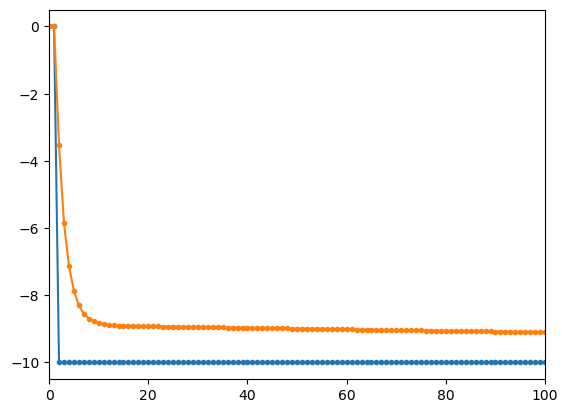

In [11]:
plt.plot(ds_fromAtm_concDriven_postspinup.delta_atmos_co2_implied,'.-')
plt.plot(ds_fromOcn_concDriven_postspinup.delta_atmos_co2_implied,'.-')
plt.xlim([0,100])

# Make jsons

In [12]:
ds_fromOcn_emisDriven_postspinup

<xarray.Dataset>
Dimensions:            (year: 1701)
Coordinates:
  * year               (year) int64 2050 2051 2052 2053 ... 3747 3748 3749 3750
Data variables: (12/102)
    hc_concentration   (year) float64 5.8 5.8 5.8 5.8 5.8 ... 5.8 5.8 5.8 5.8
    spinup             (year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    LL_DIC             (year) float64 2.219e+03 2.212e+03 ... 2.219e+03
    RF_C2F6            (year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    CH4_concentration  (year) float64 731.4 731.4 731.4 ... 731.4 731.4 731.4
    RF_HFC4310         (year) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    ...                 ...
    delta_atmos_co2    (year) float64 0.0 9.53e-06 -3.556 ... -1.135 -1.135
    delta_ocean_co2    (year) float64 0.0 -10.0 -6.444 ... -6.453 -6.453 -6.453
    fast_c             (year) float64 1.322e+04 1.322e+04 ... 1.322e+04
    slow_c             (year) float64 3.325e+04 3.326e+04 ... 3.326e+04
    delta_fast_co2     (year) float64 0.0 -10.0 -10.0 ... -5.259 -5.259 -5.259
    delta_slow_co2     (year) float64 0.0 10.0 10.0 9.535 ... 5.259 5.259 5.259

In [13]:
datasets = [ds_fromOcn_emisDriven_postspinup,ds_fromOcn_emisDriven_postspinup,
            ds_fromOcn_concDriven_postspinup, ds_fromOcn_concDriven_postspinup,
            ds_fromAtm_emisDriven_postspinup,ds_fromAtm_emisDriven_postspinup,
            ds_fromAtm_concDriven_postspinup, ds_fromAtm_concDriven_postspinup]

CDR_types=['DOR','DOR','DOR','DOR',
          'DAC','DAC','DAC','DAC']
carbon_cycle_feedbacks=['on','on','off','off',
                        'on','on','off','off']
ds_vars=['delta_atmos_co2','delta_fast_co2',
         'delta_atmos_co2_implied','delta_fast_co2_implied',
         'delta_atmos_co2','delta_fast_co2',
         'delta_atmos_co2_implied','delta_fast_co2_implied']
frames_of_reference=['atmos_co2','fast_c',
         'atmos_co2','fast_c',
         'atmos_co2','fast_c',
         'atmos_co2','fast_c']
y_axis_labels=['change_in_atmospheric_carbon','change_in_fast_carbon_pool',
        'calculated_change_in_atmospheric_carbon','calculated_change_in_fast_carbon_pool',
        'change_in_atmospheric_carbon','change_in_fast_carbon_pool',
        'calculated_change_in_atmospheric_carbon','calculated_change_in_fast_carbon_pool']

years_after_deployment=np.arange(-2,1702-3)
df_list=[]
for i, ds in enumerate(datasets):
    var_to_use=ds_vars[i]
    df=ds[var_to_use].to_dataframe(name='value')
    df['CDR_type']=CDR_types[i]
    df['carbon_cycle_feedback']=carbon_cycle_feedbacks[i]
    df['y_axis_label']=y_axis_labels[i]
    df['frame_of_reference']=frames_of_reference[i]
    df['years_after_deployment']=years_after_deployment
    df_list.append(df)
    
df_all=pd.concat(df_list)
df_all=df_all.reset_index()

In [14]:
df_all_first100years=df_all[df_all.years_after_deployment<=100]

In [15]:
df_all_first100years.to_json('DOR_vs_DAC_all_timeseries.json', orient='table')

(-3.0, 20.0)

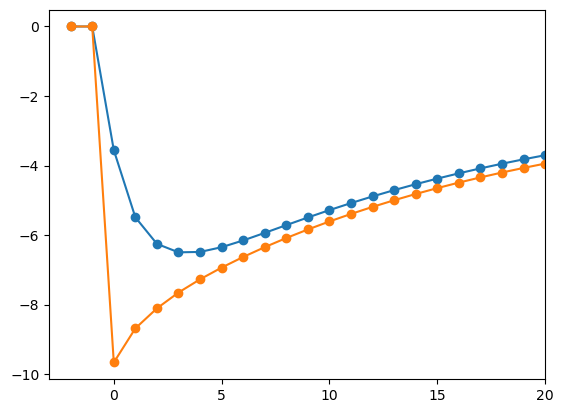

In [17]:
#Parameters to select
carbon_cycle_feedback='on'
frame_of_reference='atmos_co2'
time_horizon=10
absolute_vs_relative='absolute_drawdown' #options: 'absolute_drawdown','normalize_to_DAC'

# Get the right time series using 
tseries_to_use_DOR=df_all[(df_all.CDR_type=='DOR')&
            (df_all.carbon_cycle_feedback==carbon_cycle_feedback)&
            (df_all.frame_of_reference==frame_of_reference)]
tseries_to_use_DAC=df_all[(df_all.CDR_type=='DAC')&
            (df_all.carbon_cycle_feedback==carbon_cycle_feedback)&
            (df_all.frame_of_reference==frame_of_reference)]
plt.plot(tseries_to_use_DOR.years_after_deployment, tseries_to_use_DOR.value,'-o')
plt.plot(tseries_to_use_DAC.years_after_deployment, tseries_to_use_DAC.value,'-o')
plt.xlim([-3,20])

In [ ]:
#Parameters to select
carbon_cycle_feedback='on'
frame_of_reference='atmos_co2'
time_horizon=10
absolute_vs_relative='absolute_drawdown' #options: 'absolute_drawdown','normalize_to_DAC'

# Get the right time series using 
tseries_to_use_DOR=df_all[(df_all.CDR_type=='DOR')&
            (df_all.carbon_cycle_feedback==carbon_cycle_feedback)&
            (df_all.frame_of_reference==frame_of_reference)]
tseries_to_use_DAC=df_all[(df_all.CDR_type=='DAC')&
            (df_all.carbon_cycle_feedback==carbon_cycle_feedback)&
            (df_all.frame_of_reference==frame_of_reference)]

# Get the DOR and DAC removals at that time series
removal_DOR=tseries_to_use_DOR[tseries_to_use_DOR.years_after_deployment==time_horizon].value.item()
removal_DAC=tseries_to_use_DAC[tseries_to_use_DAC.years_after_deployment==time_horizon].value.item()

# Choose whether to display the relative or absolute removal
if absolute_vs_relative=='normalize_to_DAC':
    DOR_to_display=(removal_DOR)/(removal_DAC)
elif absolute_vs_relative=='absolute_drawdown': # doing elif here because may add a third option?
    DOR_to_display=-(removal_DOR)/10
    
# DAC is always 1
DAC_to_display=1